In [ ]:
# 1. Importing Libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_colwidth', None)

import plotly.graph_objects as go
from plotly.offline import iplot
import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)

import math
from collections import Counter
import scipy.stats as ss
from scipy.stats import pearsonr

## All feature engg in a single cell for ease

In [ ]:
df = pd.read_csv('ABC_payments_bank_credcard_train.csv')

# 1. DELETING USER ID
del df["user_id"]

# 2. AGE FROM DOB
from datetime import datetime, date


def age(born):
    born = datetime.strptime(born, "%d/%m/%Y").date()
    today = date.today()
    return today.year - born.year - ((today.month, 
                                      today.day) < (born.month, 
                                                    born.day))
  
df['Age'] = df['date_of_birth'].apply(age)
df['age_group'] = pd.cut(df.Age, bins=[0,25,35,45,55,65,75,99], labels =['0-25','25-35','35-45','45-55','55-65','65-75','75-99'])


# 6. EDUCATINO GROUPS
df['edu_group'] = pd.cut(df.education_num, bins=[0,2,6,8,10,12,13,14,17], labels =['pre','matri','hs','diplo','asso','grad','pg','phd'])

# 8. Imputing asset_class_cd
df["asset_class_cd"].fillna("-1", inplace = True)

def change(value):
    if value == '1':
        value = 'S'
    return value
        
df['asset_class_cd'] = df['asset_class_cd'].apply(change)


# 9. Transforming cap_gain and cap_loss
df['net_cap_gain'] = df['capital_gain']-df['capital_loss']

## RELATIONSHIP ADDITIONAL COLUMN
def grouping_relationship(t):
    if t == ' Husband' or t== ' Wife':
        return 1
    else:
        return 0    
df['husb_or_wife'] = df['relationship'].apply(grouping_relationship)


df['gender'] = df['gender'].str.strip()
df['occupation'] = df['occupation'].str.strip()
df['relationship'] = df['relationship'].str.strip()
df['marital_status'] = df['marital_status'].str.strip()
df['education_level'] = df['education_level'].str.strip()
df['workclass'] = df['workclass'].str.strip()

# TEST SET AND TRAIN SET
df_train = df.sample(frac=0.8, random_state = 25)
df_test = df.drop(df_train.index)


# 9. Imputing inquiry purpose code
df_train['inquiry_purpose_code'] = df_train['inquiry_purpose_code'].fillna(df_train['inquiry_purpose_code'].mode()[0])
df_test['inquiry_purpose_code'] = df_test['inquiry_purpose_code'].fillna(df_train['inquiry_purpose_code'].mode()[0])

#10. Imputing asset code
df_train['asset_code'] = df_train['asset_code'].fillna(df_train['asset_code'].mode()[0])
df_test['asset_code'] = df_test['asset_code'].fillna(df_train['asset_code'].mode()[0])

#11. Imputation portfolio type
df_train['portfolio_type'] = df_train['portfolio_type'].fillna(df_train['portfolio_type'].mode()[0])
df_test['portfolio_type'] = df_test['portfolio_type'].fillna(df_train['portfolio_type'].mode()[0])

df_train['inquiry_purpose_code'] = df_train.inquiry_purpose_code.astype('category')
df_train['institute_type'] = df_train.institute_type.astype('category')
df_train['account_type'] = df_train.account_type.astype('category')
df_train['asset_class_cd'] = df_train.asset_class_cd.astype('object')
df_train['asset_code'] = df_train.asset_code.astype('object')
df_train['portfolio_type']= df_train.portfolio_type.astype('object')

df_test['inquiry_purpose_code']=df_test.inquiry_purpose_code.astype('object')
df_test['institute_type']=df_test.institute_type.astype('object')
df_test['account_type']=df_test.account_type.astype('object')
df_test['asset_class_cd']=df_test.asset_class_cd.astype('object')
df_test['asset_code']=df_test.asset_code.astype('object')
df_test['portfolio_type']=df_test.portfolio_type.astype('object')

## Important functions used

In [ ]:
import category_encoders as ce
from sklearn import preprocessing

from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.preprocessing import OneHotEncoder

from sklearn import metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import  plot_precision_recall_curve, plot_roc_curve, plot_confusion_matrix
     
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

In [ ]:
def label_encoding(df):
    
    enc_lab = ce.OrdinalEncoder(return_df=True)
    df = enc_lab.fit_transform(df)
    return df, enc_lab

In [ ]:
def one_hot_encoding(col):

    length = len(df_train[col])
    df_net = df_train[col].merge(df_test[col])
    df_net = pd.get_dummies(df_net)
    
    df_1_one = df_net[:length]
    df_2_one = df_net[length:]
    df_2_one = df_2_one.reindex(columns = df_1_one.columns, fill_value=0)
    return df_1_one, df_2_one

In [ ]:
def target_encoding(df_to_enc):
    
    enc_tar = ce.TargetEncoder(cols = df_to_enc.columns, smoothing = 850) 
    df_enc = enc_tar.fit_transform(df_to_enc, df_train['approved'])
    return df_enc, enc_tar

In [ ]:
def models(x,y, x_test, y_test):
    
    # LIGHT BGM
    model_lgbm = LGBMClassifier()
    model_lgbm.fit(x, y)
    y_pred_train = cross_val_predict(model_lgbm, x, y, cv= 5)
    y_pred_train = y_pred_train.reshape((-1,1))
    y_test = y_test.to_numpy().reshape((-1,1))
    y = y.to_numpy().reshape((-1,1))
    print('\n \n FOR LIGHT GBM')
    print('roc_auc_score for training is', metrics.roc_auc_score(y,y_pred_train))
    print('precision for training is',metrics.precision_score(y,y_pred_train), '\n Recall for training is',metrics.recall_score(y,y_pred_train),'\n f1_score is', metrics.f1_score(y,y_pred_train))
    # for test set
    y_pred_test = model_lgbm.predict(x_test)
    y_pred_test = y_pred_test.reshape((-1,1))
    print('roc_auc_score for test is', metrics.roc_auc_score(y_test,y_pred_test),'\n precision for test is',metrics.precision_score(y_test,y_pred_test), '\n recall for test is',metrics.recall_score(y_test,y_pred_test),'\n f1_score is', metrics.f1_score(y_test,y_pred_test))
    plot_confusion_matrix(model_lgbm, x_test, y_test)
    plt.show()

    return model_lgbm

# Adding incomes

In [ ]:
def inc_occ(occupation, gender):
    if occupation =='Armed-Forces':
        if gender == 'Male':
            return 51844
        else:
            return 41903
    elif occupation =='Protective-serv':
        if gender == 'Male':
            return 55317
        else:
            return 34206
    elif occupation =='Priv-house-serv': 
        if gender == 'Male':
            return 26822
        else:
            return 16811
    elif occupation =='Other-service':
        if gender == 'Male':
            return 22219
        else:
            return 20788
    elif occupation =='Farming-fishing':
        if gender == 'Male':
            return 26822
        else:
            return 16811
    elif occupation =='Prof-specialty':
        if gender == 'Male':
            return 72039
        else:
            return 50711
    elif occupation =='Machine-op-inspct':
        if gender == 'Male':
            return 39372
        else:
            return 34335
    elif occupation =='Sales':
        if gender == 'Male':
            return 48908
        else:
            return 24920
    elif occupation =='Transport-moving':
        if gender == 'Male':
            return 33292
        else:
            return 23157
    elif occupation =='Exec-managerial':
        if gender == 'Male':
            return 80366
        else:
            return 60576
    elif occupation =='Handlers-cleaners':
        if gender == 'Male':
            return 28163
        else:
            return 18701
    elif occupation =='Craft-repair':
        if gender == 'Male':
            return 42807
        else:
            return 27609
    elif occupation =='Adm-clerical':
        if gender == 'Male':
            return 39372
        else:
            return 34335
    elif occupation =='Tech-support':
        if gender == 'Male':
            return 48908
        else:
            return 24920
        
df_train['income_occ'] = df_train.apply(lambda x: inc_occ(x.occupation, x.gender), axis=1)
df_test['income_occ'] = df_test.apply(lambda x: inc_occ(x.occupation, x.gender), axis=1)

In [ ]:
def inc_age(agrp,gender):
    if agrp == '0-25':
        if gender == 'Male':
            return 20757
        else:
            return 18964
    elif agrp == '25-35':
        if gender == 'Male':
            return 54139
        else:
            return 42510

    elif agrp == '35-45':
        if gender == 'Male':
            return 79132
        else:
            return 53500
    elif agrp == '45-55':
        if gender == 'Male':
            return 86724
        else:
            return 57151
    elif agrp == '55-65':
        if gender == 'Male':
            return 81676
        else:
            return 49168
    else:
        if gender == 'Male':
            return 58576
        else:
            return 35316
        
df_train['income_age'] = df_train.apply(lambda x: inc_age(x.age_group, x.gender), axis=1)
df_test['income_age'] = df_test.apply(lambda x: inc_age(x.age_group, x.gender), axis=1)

In [ ]:
def inc_rel(relation, gender):
    if relation =='Husband' or relation =='Wife' :
        if gender == ' Male':
            return 55727
        else:
            return 33198
    if relation =='Other-relative':
        if gender == 'Male':
            return 25416
        else:
            return 20601
    if relation =='Own-child':
        if gender == 'Male':
            return 16471
        else:
            return 14152
    if relation =='Unmarried'or relation == 'Not-in-family':
        if gender == 'Male':
            return 52271
        else:
            return 31968


df_train['income_rel'] = df_train.apply(lambda x: inc_rel(x.relationship, x.gender), axis=1)        
df_test['income_rel'] = df_test.apply(lambda x: inc_rel(x.relationship, x.gender), axis=1)

In [ ]:
def inc_ms(status, gender):
    

    if status =='Married-civ-spouse' or status =='Married-AF-spouse' :
        if gender == 'Male':
            return 57404
        else:
            return 32743
    if status =='Widowed' or status == 'Separated':
        if gender == 'Male':
            return 42286
        else:
            return 34502
    if status =='Married-spouse-absent':
        if gender == 'Male':
            return 37764
        else:
            return 26408
    if status =='Divorced':
        if gender == 'Male':
            return 42286
        else:
            return 34502
    if status =='Never-married':
        if gender == 'Male':
            return 28581
        else:
            return 26420


df_train['income_mar_st'] = df_train.apply(lambda x: inc_ms(x.marital_status, x.gender), axis=1)        
df_test['income_mar_st'] = df_test.apply(lambda x: inc_ms(x.marital_status, x.gender), axis=1)

In [ ]:
def inc_ed(education, gender):
    
        
    if education =='Doctorate' :
        if gender == 'Male':
            return 106472
        else:
            return 86047
    elif education =='Prof-school' :
        if gender == 'Male':
            return 127625
        else:
            return 82093
    elif education =='Masters' :
        if gender == 'Male':
            return 88280
        else:
            return 66601
    elif education =='Bachelors' :
        if gender == 'Male':
            return 69505
        else:
            return 45942
    
    elif education =='Assoc-voc' or education == 'Assoc-acdm':
        if gender == 'Male':
            return 51250
        else:
            return 31652
    elif education =='Some-college' :
        if gender == 'Male':
            return 45639
        else:
            return 28653
    elif education =='HS-grad' :
        if gender == 'Male':
            return 37144
        else:
            return 22052
    else :
        if gender == 'Male':
            return 24420
        else:
            return 13129
    


df_train['income_ed'] = df_train.apply(lambda x: inc_ed(x.education_level, x.gender), axis=1)        
df_test['income_ed'] = df_test.apply(lambda x: inc_ed(x.education_level, x.gender), axis=1)

In [ ]:
def inc_work(workclass, occupation, gender):

        
    if workclass =='Private' :
        if gender == 'Male':
            if occupation == 'Farming-fishing':
                return 30231
            else:
                return 46956
        else:
            if occupation == 'Farming-fishing':
                return 21440
            else:
                return 34321
    if workclass =='Self-emp-inc' or workclass =='Self-emp-not-inc' :
        if gender == 'Male':
            if occupation == 'Farming-fishing':
                return 36081
            else:
                return 50380
        else:
            if occupation == 'Farming-fishing':
                return 25083
            else:
                return 30393
    if workclass =='Local-gov' or workclass == 'State-gov' :
        if gender == 'Male':
            return 55030
        else:
            return 42460
    if workclass =='Federal-gov' :
        if gender == 'Male':
            return 66964
        else:
            return 60727
    else:
        return 0



df_train['income_workclass'] = df_train.apply(lambda x: inc_work(x.workclass, x.occupation, x.gender), axis=1)        
df_test['income_workclass'] = df_test.apply(lambda x: inc_work(x.workclass, x.occupation, x.gender), axis=1)

In [ ]:
df_train['income_occ_age'] = (df_train['income_occ']+df_train['income_age'])/2
df_test['income_occ_age'] = (df_test['income_occ']+df_test['income_age'])/2

In [ ]:
df_test['net_income_occ_age_edu'] = (df_test['income_occ_age']+ df_test['income_ed'])/2
df_train['net_income_occ_age_edu'] = (df_train['income_occ_age']+ df_train['income_ed'])/2

# Final model

1. Taking different combinations of coloumns for label, One hot and target 
2. Trying additional features developed

* AUC_ROC: 81.5
* Precision: 78
* Recall: 70

1. Label encoded:  gender
2. Target: Age, account_type, edu_group,  asset_code, Occupation, inquiry purpose code, relationship, marital status, workclass
3. No changes: husb_or_wife, net_cap_gain



 
 FOR LIGHT GBM
roc_auc_score for training is 0.8106825930329251
precision for training is 0.7874247098574997 
 Recall for training is 0.6813270624126097 
 f1_score is 0.7305438189995912
roc_auc_score for test is 0.8160709583868442 
 precision for test is 0.7777161862527716 
 recall for test is 0.6990533134030892 
 f1_score is 0.7362896877459985


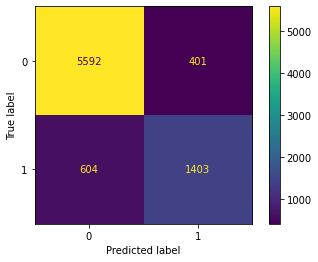

In [ ]:
targ_col1 = ['account_type','edu_group','asset_code','institute_type', 'occupation','inquiry_purpose_code','relationship','marital_status','workclass']
label_col1 = ['gender']


x1, encoder1 = target_encoding(df_train[targ_col1])
x1_test_main1 = encoder1.transform(df_test[targ_col1])


x3, encoder2 = label_encoding(df_train[label_col1])
x3_test_main3 = encoder2.transform(df_test[label_col1])


x = x1.join(x3)
x_test_main = x1_test_main1.join(x3_test_main3)


x['hours_per_week'] = df_train['hours_per_week']
x_test_main['hours_per_week'] = df_test['hours_per_week']

x['income'] = np.log(df_train['net_income_occ_age_edu'])
x_test_main['income'] = np.log(df_test['net_income_occ_age_edu'])

x['net_cap_gain'] = df_train['net_cap_gain']
x_test_main['net_cap_gain'] = df_test['net_cap_gain']

x['Age'] = df_train['Age']
x_test_main['Age'] = df_test['Age']


y = df_train['approved']
y_test_main = df_test['approved']

model_lgbm = models(x,y,x_test_main,y_test_main)

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(model_lgbm.feature_importances_,x.columns)), columns=['Value','Feature'])


fig = px.bar(feature_imp.sort_values(by="Value", ascending=True), x='Value', y='Feature', title="LightGBM Features (avg over folds)")
fig.show()

# Checking with different smoothening

In [ ]:
score_sm_precision = []
score_sm_recall = []
score_sm_auc = []

for i in range (1,1000,10):
    a=[]

    targ_col1 = ['account_type','edu_group','asset_code','inquiry_purpose_code','institute_type', 'occupation','relationship','marital_status','workclass']
    label_col1 = ['gender']

    encoder1 = ce.TargetEncoder(smoothing = i) 
    x1 = encoder1.fit_transform(df_train[targ_col1], df_train['approved'])
    x1_test_main1 = encoder1.transform(df_test[targ_col1])

    encoder2 = ce.OrdinalEncoder(return_df=True)
    x2 = encoder2.fit_transform(df_train[label_col1])
    x2_test_main2 = encoder2.transform(df_test[label_col1])

    x = x1.join(x2) 
    x_test_main = x1_test_main1.join(x2_test_main2)

    x['hours_per_week'] = df_train['hours_per_week']
    x_test_main['hours_per_week'] = df_test['hours_per_week']

    x['income'] = df_train['net_income_occ_age_edu']
    x_test_main['income'] = df_test['net_income_occ_age_edu']

    x['net_cap_gain'] = df_train['net_cap_gain']
    x_test_main['net_cap_gain'] = df_test['net_cap_gain']

    x['Age'] = np.log(df_train['Age'])
    x_test_main['Age'] = np.log(df_test['Age'])

    y = df_train['approved']
    y_test_main = df_test['approved']


    model_lgbm = LGBMClassifier()
    model_lgbm.fit(x, y)
    y_pred_train = cross_val_predict(model_lgbm, x, y, cv= 4)
    y_pred_train = y_pred_train.reshape((-1,1))
    y_pred_test = model_lgbm.predict(x_test_main)
            
    score_sm_precision.append(metrics.precision_score(y_test_main,y_pred_test))
    score_sm_recall.append(metrics.recall_score(y_test_main,y_pred_test))
    score_sm_auc.append(metrics.roc_auc_score(y_test_main,y_pred_test))

In [ ]:
a = []
for i in range (1,1000,10):
    a.append(i)
    
fig = px.scatter(x=a,y=score_sm_precision)
fig.add_scatter(x=a, y = score_sm_recall)
fig.add_scatter(x=a, y = score_sm_auc)
fig.show()

# Checking threshold
* Selecting threshold as 0.42

In [ ]:
precision_score = []
recall_score = []
auc_score = []
for i in range(1,100,1):
    
    a=[]
    targ_col1 = ['account_type','edu_group','asset_code','inquiry_purpose_code','institute_type', 'occupation','relationship','marital_status','workclass']
    label_col1 = ['gender']


    encoder1 = ce.TargetEncoder(smoothing = 850) 
    x1 = encoder1.fit_transform(df_train[targ_col1], df_train['approved'])
    x1_test_main1 = encoder1.transform(df_test[targ_col1])

    encoder2 = ce.OrdinalEncoder(return_df=True)
    x2 = encoder2.fit_transform(df_train[label_col1])
    x2_test_main2 = encoder2.transform(df_test[label_col1])

    x = x1.join(x2) #(x1.join(x2)).join(x3)
    x_test_main = x1_test_main1.join(x2_test_main2)#(x1_test_main1.join(x2_test_main2)).join(x3_test_main3)


    x['hours_per_week'] = df_train['hours_per_week']
    x_test_main['hours_per_week'] = df_test['hours_per_week']

    x['income'] = df_train['net_income_occ_age_edu']
    x_test_main['income'] = df_test['net_income_occ_age_edu']

    x['net_cap_gain'] = df_train['net_cap_gain']
    x_test_main['net_cap_gain'] = df_test['net_cap_gain']

    x['Age'] = df_train['Age']
    x_test_main['Age'] = df_test['Age']

    y = df_train['approved']
    y_test_main = df_test['approved']


    y = df_train['approved']
    y_test_main = df_test['approved']


    model_lgbm = LGBMClassifier()
    
    model_lgbm.fit(x, y)
    y_pred_train = cross_val_predict(model_lgbm, x, y, cv= 4)
    y_pred_train = y_pred_train.reshape((-1,1))
    y_pred_test = model_lgbm.predict_proba(x_test_main)

    for j in y_pred_test:
        if j[1] > i/100:
            a.append(1)
        else:
            a.append(0)
        
    precision_score.append(metrics.precision_score(y_test_main,a))
    recall_score.append(metrics.recall_score(y_test_main,a))
    auc_score.append(metrics.roc_auc_score(y_test_main,a))
    

In [ ]:
b = []
for i in range(1,100,1):
    b.append(i)

trace1 = go.Scatter(
    x=b,
    y = recall_score,
    mode = "markers",
    opacity=0.75,
    name = "Recall",
    marker=dict(color='rgba(71, 50, 96, 0.6)'))
trace2 = go.Scatter(
    x=b,
    y = precision_score,
    mode = "markers",
    opacity=0.75,
    name = "Precision",
    marker=dict(color='rgba(12, 150, 196, 0.6)'))
trace3 = go.Scatter(
    x= b,
    y=auc_score,
    mode = "markers",
    marker = dict(color = 'rgba(180, 26, 80, 0.8)'),
    opacity=0.75,
    name = "AUC_ROC")

data = [trace1, trace2, trace3]
layout = go.Layout(title=' Accuracy_Metrics')
fig = go.Figure(data=data)
iplot(fig)

# Hyperparameter tuning

In [ ]:
targ_col1 = ['account_type','edu_group','asset_code','inquiry_purpose_code','institute_type', 'occupation','relationship','marital_status','workclass']
label_col1 = ['gender']


encoder1 = ce.TargetEncoder(smoothing = 850) 
x1 = encoder1.fit_transform(df_train[targ_col1], df_train['approved'])
x1_test_main1 = encoder1.transform(df_test[targ_col1])

encoder2 = ce.OrdinalEncoder(return_df=True)
x2 = encoder2.fit_transform(df_train[label_col1])
x2_test_main2 = encoder2.transform(df_test[label_col1])

x = x1.join(x2) #(x1.join(x2)).join(x3)
x_test_main = x1_test_main1.join(x2_test_main2)#(x1_test_main1.join(x2_test_main2)).join(x3_test_main3)


x['hours_per_week'] = df_train['hours_per_week']
x_test_main['hours_per_week'] = df_test['hours_per_week']

x['income'] = np.log(df_train['net_income_occ_age_edu'])
x_test_main['income'] = np.log(df_test['net_income_occ_age_edu'])

x['net_cap_gain'] = df_train['net_cap_gain']
x_test_main['net_cap_gain'] = df_test['net_cap_gain']

x['Age'] = df_train['Age']
x_test_main['Age'] = df_test['Age']

y = df_train['approved']
y_test_main = df_test['approved']


y = df_train['approved']
y_test_main = df_test['approved']


model_lgbm = LGBMClassifier(n_estimators = 20000, 
max_depth= 6, 
learning_rate= 0.014564209621859385, 
reg_lambda= 29.326, 
subsample= 0.818, 
colsample_bytree= 0.235)

model_lgbm.fit(x, y)
y_pred_train = cross_val_predict(model_lgbm, x, y, cv= 4)
y_pred_train = y_pred_train.reshape((-1,1))
y_pred_test = model_lgbm.predict(x_test_main)

print('precision', metrics.precision_score(y_test_main,y_pred_test))
print('recall', metrics.recall_score(y_test_main,y_pred_test))
print('auc',metrics.roc_auc_score(y_test_main,y_pred_test))



[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
precision 0.7711956521739131
recall 0.7070254110612855
auc 0.8183883938336629


In [ ]:
import pickle
filename = 'tuned_lgbm_model.pkl'
pickle.dump(model_lgbm, open(filename, 'wb'))

# Credit limit strategy



# Setting threshold using number of TP, FP

In [ ]:
from  sklearn.model_selection import cross_val_score
score = cross_val_score(model_lgbm,x,y,cv=5, scoring='precision')
print(score.mean())

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
0.7776810950428699


In [ ]:
# Defining raw test data set
x_test_raw = (df_test[targ_col1]).join(df_test[['net_income_occ_age_edu','income_workclass','income_rel','income_occ','income_mar_st','income_ed','income_age','gender','education_num','hours_per_week','husb_or_wife','net_income_occ_age_edu','net_cap_gain','Age','approved']])
y_pred_test = model_lgbm.predict_proba(x_test_main)

dumm_df = pd.DataFrame(y_pred_test, columns = ['prob_0','prob'])
x_test_raw.reset_index(inplace = True)
x_test_raw = pd.merge(x_test_raw, dumm_df['prob'], left_index=True, right_index=True)

In [ ]:
# assigning predicted approved based on prob
pred_approved = []
for i in range(0,8000):
    if x_test_raw['prob'][i] > 0.42:
        pred_approved.append(1)
    else:
        pred_approved.append(0)
        
x_test_raw['pred_app'] = pred_approved

In [ ]:
#PLOTTING no of TP, FP for different threshold
threshold = []
TP = []
TN = []
FP = []
FN = []
x_test_raw['pred_app'] = 0
for k in range (2,100,2):
    pred_approved = []
    
    for i in x_test_raw.index:
        if x_test_raw['prob'][i] > k/100:
            pred_approved.append(1)
        else:
            pred_approved.append(0)
    
    x_test_raw['pred_app'] = pred_approved
            
    x_test_raw['label']=0
    label = []
    for j in x_test_raw.index:
        if ((x_test_raw['pred_app'][j] == 0) & (x_test_raw['approved'][j] == 0)):
            label.append('TN')

        elif  ((x_test_raw['pred_app'][j] == 1) & (x_test_raw['approved'][j] == 1)):
            label.append('TP')

        elif  ((x_test_raw['pred_app'][j] == 1) & (x_test_raw['approved'][j] == 0)):
            label.append('FP')

        elif  ((x_test_raw['pred_app'][j] == 0) & (x_test_raw['approved'][j] == 1)):
            label.append('FN')

    x_test_raw['label'] = label
    
    TN.append(x_test_raw[x_test_raw['label']=='TN']['label'].count())
    TP.append(x_test_raw[x_test_raw['label']=='TP']['label'].count())
    FN.append(x_test_raw[x_test_raw['label']=='FN']['label'].count())
    FP.append(x_test_raw[x_test_raw['label']=='FP']['label'].count())
    
for i in range(2,100,2):
    threshold.append(i)

trace1 = go.Scatter(
    x=threshold,
    y = TP,
    mode = "markers",
    opacity=0.75,
    name = "TP",
    marker=dict(color='rgba(71, 50, 96, 0.6)'))
trace2 = go.Scatter(
    x= threshold,
    y = TN,
    mode = "markers",
    opacity=0.75,
    name = "TN",
    marker=dict(color='rgba(12, 150, 196, 0.6)'))
trace3 = go.Scatter(
    x= threshold,
    y= FP,
    mode = "markers",
    marker = dict(color = 'rgba(180, 26, 80, 0.8)'),
    opacity=0.75,
    name = "FP")
trace4 = go.Scatter(
    x= threshold,
    y= FN,
    mode = "markers",
    marker = dict(color = 'rgba(100, 56, 180, 0.8)'),
    opacity=0.75,
    name = "FN")

data = [trace1, trace2, trace3, trace4]
fig = go.Figure(data=data)
iplot(fig)

In [ ]:
fig = px.scatter(y_label, y="prob", color = 'label',color_discrete_sequence=px.colors.qualitative.Vivid_r)
fig.show()

In [ ]:
# Determining labels for threshold 0.42
x_test_raw['pred_app'] = -1
x_test_raw['label'] = 0
pred_approved = []
for i in range(0,8000):
    if x_test_raw['prob'][i] > 0.42:
        pred_approved.append(1)
    else:
        pred_approved.append(0)
        
x_test_raw['pred_app'] = pred_approved
        
x_test_raw['label']=0
label = []
for j in x_test_raw.index:
    if ((x_test_raw['pred_app'][j] == 0) & (x_test_raw['approved'][j] == 0)):
        label.append('TN')

    elif  ((x_test_raw['pred_app'][j] == 1) & (x_test_raw['approved'][j] == 1)):
        label.append('TP')

    elif  ((x_test_raw['pred_app'][j] == 1) & (x_test_raw['approved'][j] == 0)):
        label.append('FP')

    elif  ((x_test_raw['pred_app'][j] == 0) & (x_test_raw['approved'][j] == 1)):
        label.append('FN')

x_test_raw['label'] = label

# Final strategy

In [ ]:
# Considering weighted average with prob with tuned weights
df_train['net_averaged_income']=(10*df_train['income_age']+80*df_train['net_cap_gain']+200*df_train['income_ed']+110*df_train['income_mar_st']+50*df_train['income_rel'] + 540*df_train['income_occ']+70*df_train['income_workclass'])
df_test['net_averaged_income'] = (10*df_test['income_age']+80*df_test['net_cap_gain'] +200*df_test['income_ed'] + 110*df_test['income_mar_st'] + 50*df_test['income_rel']+ 540*df_test['income_occ'] +70*df_test['income_workclass'] )

max_net_income = max(df_train['net_averaged_income'])
max_net_cap_gain = max(df_train['net_cap_gain'])


a=0.35
x_test_raw['net_income'] = (df_test.reset_index()['net_averaged_income']*a/(max_net_income)+x_test_raw['prob']*(1-a))*8000
x_test_raw['net_income'] = x_test_raw['net_income'].apply(lambda x: 1000 if x < 3000 else 8000 if x>5800 else x)

    
revenue = x_test_raw[x_test_raw['label']=='TP']['net_income'].sum()
psuedo_loss = x_test_raw[x_test_raw['label']=='FN']['net_income'].sum()
actual_loss = x_test_raw[x_test_raw['label']=='FP']['net_income'].sum()
total_credit = x_test_raw['net_income'].sum()


print('Revenue :',revenue,'\nPsuedo loss:',psuedo_loss,'\nActual loss:', actual_loss )

Revenue : 10187657.423789848 
Psuedo loss: 913823.2272711447 
Actual loss: 2761497.699459118


In [ ]:
fig = px.scatter(x_test_raw, y="net_income", color = 'approved',color_discrete_sequence=px.colors.qualitative.Vivid_r)
fig.show()

In [ ]:
# Optimising the max credit strategy by changing coeff
revenue =[]
profit = []
actual_loss = []
psuedo_loss = []

for i in range(0,700,10):
    df_train['net_averaged_income']=(i*df_train['income_age']+80*df_train['net_cap_gain']+200*df_train['income_ed']+110*df_train['income_mar_st']+50*df_train['income_rel'] + 540*df_train['income_occ']+50*df_train['income_workclass'])
    df_test['net_averaged_income'] = (i*df_test['income_age']+80*df_test['net_cap_gain'] +200*df_test['income_ed'] + 110*df_test['income_mar_st'] + 50*df_test['income_rel']+ 540*df_test['income_occ'] +50*df_test['income_workclass'] )

    max_net_income = max(df_train['net_averaged_income'])
    max_net_cap_gain = max(df_train['net_cap_gain'])


    a=0.35
    x_test_raw['net_income'] = (df_test.reset_index()['net_averaged_income']*a/(max_net_income)+x_test_raw['prob']*(1-a))*8000
    x_test_raw['net_income'] = x_test_raw['net_income'].apply(lambda x: 1000 if x < 3000 else 8000 if x>5700 else x)

    revenue1 = x_test_raw[x_test_raw['label']=='TP']['net_income'].sum()
    psuedo_loss1 = x_test_raw[x_test_raw['label']=='FN']['net_income'].sum()
    actual_loss1 = x_test_raw[x_test_raw['label']=='FP']['net_income'].sum()
    profit1 = revenue1-psuedo_loss1-actual_loss1

    revenue.append(revenue1)
    profit.append(profit1)
    actual_loss.append(actual_loss1)
    psuedo_loss.append(psuedo_loss1)